In [1]:
from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

import pandas as pd
import numpy as np

from IPython.display import display, Markdown

import locale
_ = locale.setlocale(locale.LC_ALL, "it_IT")

In [2]:
def smooth(y):
    y_smoothed = y.rolling(7,
            win_type='gaussian',
            min_periods=1,
            center=True).mean(std=2).round()
    return y_smoothed

ita = None
url_ita = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
ita = pd.read_csv(url_ita,
                     usecols=['data', 'totale_positivi', 'dimessi_guariti', 'deceduti'],
                     parse_dates=['data'],
                     index_col=['data'],
                     squeeze=True).sort_index()

dI = ita["totale_positivi"].diff()[1:]
dR = ita["dimessi_guariti"].diff()[1:]
dD = ita["deceduti"].diff()[1:]

dI_s = smooth(dI)
dR_s = smooth(dR)
dD_s = smooth(dD)

_R0 = (dI_s / (dR_s + dD_s)) + 1
R0 = pd.DataFrame(
    data={"R0": _R0.values},
    index=dI.index
)

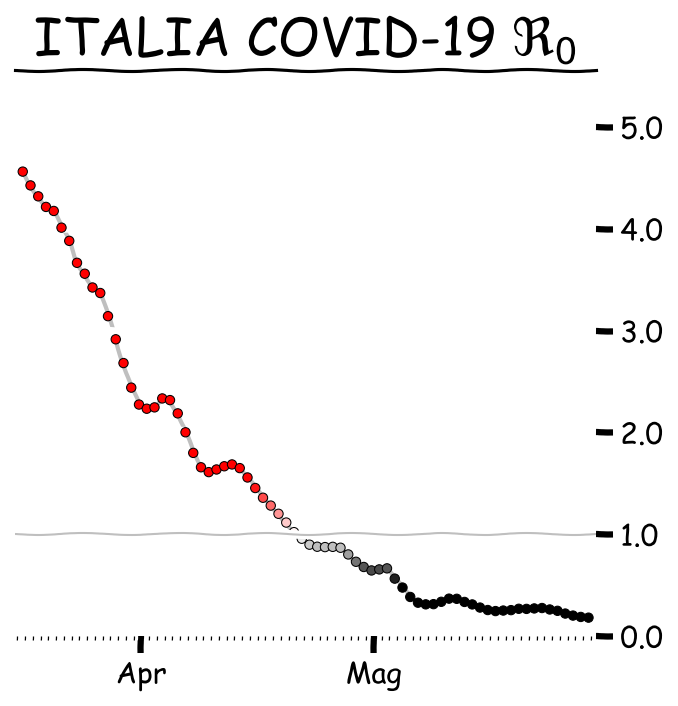

In [4]:
def plot_r0(result, state_name, offset=10):
    
    with plt.xkcd():
        fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150)

        ax.set_title(f"{state_name} $\Re_0$", fontsize=25)

        # Colors
        ABOVE = [1,0,0]
        MIDDLE = [1,1,1]
        BELOW = [0,0,0]
        cmap = ListedColormap(np.r_[
            np.linspace(BELOW,MIDDLE,25),
            np.linspace(MIDDLE,ABOVE,25)
        ])
        color_mapped = lambda y: np.clip(y, .5, 1.5)-.5

        index = result.index.get_level_values('data')[offset:]
        values = result["R0"].values[offset:]

        # Plot dots and line
        ax.plot(index, values, c='k', zorder=1, alpha=.25)
        ax.scatter(index,
                   values,
                   s=20,
                   lw=.5,
                   c=cmap(color_mapped(values)),
                   edgecolors='k', zorder=2)

        extended = [
            pd.Timestamp(index[0]) - pd.Timedelta(days=1),
            index[-1] + pd.Timedelta(days=1)
        ]

        ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);

        # Formatting
        #ax.xaxis.set_major_locator(mdates.WeekdayLocator())
        #ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))

        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
        #ax.tick_params(axis="x", which='major', labelsize=12, pad=15)
        ax.xaxis.set_minor_locator(mdates.DayLocator())
        #ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
        #ax.tick_params(axis="x", which='minor', labelsize=9)

        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
        ax.yaxis.tick_right()
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.margins(0)
        ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
        ax.margins(0)
        ax.set_ylim(0.0, max(values) + 1)
        ax.set_xlim(extended)
        fig.set_facecolor('w')
    plt.show()
    
plot_r0(R0, "ITALIA COVID-19", offset=20)

In [111]:
italy = None
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
italy = pd.read_csv(url,
                     usecols=['data', 'totale_casi'],
                     parse_dates=['data'],
                     index_col=['data'],
                     squeeze=True).sort_index()

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7.5

def prepare_cases(cases, cutoff=1, win=7, std=2):

    new_cases = cases.diff()
    new_cases[new_cases < 0] = 0

    smoothed = new_cases.rolling(win,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=std).round()
    
    idx_start = np.searchsorted(smoothed, cutoff)
    
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

def highest_density_interval(pmf, p=.95):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)

    cumsum = np.cumsum(pmf.values)

    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]

    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()

    try:
        # Find the smallest range (highest density)
        best = (highs - lows).argmin()
    except Exception as e:
        print("ERR {}".format(e))
        best = 0

    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]

    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])

def HDIs(pmf, P=[.95, .5]):
    RES = []
    for p in P:
        res = highest_density_interval(pmf, p=p)
        RES.append(res)
    return RES


def get_posteriors(sr, sigma=0.15):

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

def plot_rt(result, state_name, P=[.95, .5], days=60):
    
    result = result.loc[result.index[-1]-pd.Timedelta(days=days):]
    
    with plt.xkcd():
        fig, ax = plt.subplots(figsize=(7,7))
        ax.set_title(f"{state_name} Numero di Riproduzione Effettivo", fontsize=20)

        # Colors
        ABOVE = [1,0,0]
        MIDDLE = [1,1,1]
        BELOW = [0,0,0]
        cmap = ListedColormap(np.r_[
            np.linspace(BELOW,MIDDLE,25),
            np.linspace(MIDDLE,ABOVE,25)
        ])
        color_mapped = lambda y: np.clip(y, .5, 1.5)-.5

        index = result['ML'].index.get_level_values('data')
        values = result['ML'].values

        # Plot dots and line
        ax.plot(index, values, c='r', zorder=3, alpha=.75)
        #ax.scatter(index,
        #           values,
        #           s=[20+40*np.random.random() for _ in range(index.size)],
        #           lw=.25,
        #           c=cmap(color_mapped(values)),
        #           edgecolors='k', zorder=2)

        #extended = pd.date_range(start=pd.Timestamp('2020-02-24'),
        #                     end=index[-1]+pd.Timedelta(days=1))
        extended = pd.date_range(start=index[0]-pd.Timedelta(days=1),
                             end=index[-1]+pd.Timedelta(days=1))

        # Aesthetically, extrapolate credible interval by 1 day either side
        for j, p in enumerate(P):
            lowfn = interp1d(date2num(index),
                             result[f'Low_{p*100:.0f}'].values,
                             bounds_error=False,
                             fill_value='extrapolate')

            highfn = interp1d(date2num(index),
                              result[f'High_{p*100:.0f}'].values,
                              bounds_error=False,
                              fill_value='extrapolate')



            ax.fill_between(extended,
                            lowfn(date2num(extended)),
                            highfn(date2num(extended)),
                            color='k',
                            alpha=.1*(j+1),
                            lw=0,
                            zorder=3+j)

        ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25, zorder=2)

        # Formatting
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%B'))
        ax.xaxis.set_minor_locator(mdates.DayLocator())

        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
        ax.yaxis.tick_right()
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.margins(0)
        ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-100)
        ax.margins(0)
        ax.set_ylim(0.0, 2.0)
        ax.set_xlim(index[0]-pd.Timedelta(days=1), result.index.get_level_values('data')[-1]+pd.Timedelta(days=1))
        ax.text(
            index[index.size//2], 1.9,
            f"Ultimo Rt\n{index[-1].date()}\n{values[-1]}\n({result['Low_95'].values[-1]}-{result['High_95'].values[-1]})",
            ha="center", va="top", fontsize=20,
        )
        ax.text(
            index[0], 0,
            "Max Pierini",
            ha="left", va="bottom"
        )
        fig.set_facecolor('w')
    plt.show()

In [13]:
original, smoothed = prepare_cases(italy, win=8, std=2.5)

# Note that we're fixing sigma to a value just for the example
posteriors, log_likelihood = get_posteriors(smoothed, sigma=.20)

# Note that this takes a while to execute - it's not the most efficient algorithm
#hdis = highest_density_interval(posteriors)
HDIS = HDIs(posteriors)

most_likely = posteriors.idxmax().rename('ML')

result = most_likely
for hdis in HDIS:
    result = pd.concat([result, hdis], axis=1)

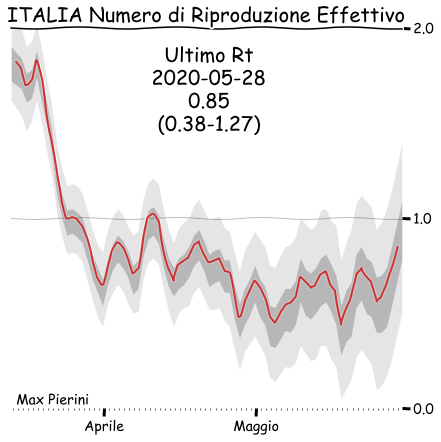

In [112]:
plot_rt(result, "ITALIA", days=75)